In [20]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import phate
import scprep, scanpy
from sklearn import model_selection, linear_model, metrics
import pandas as pd

In [10]:
data = scanpy.read_h5ad('./data/processed_data.h5ad')
patient_label = data.obs[['patient','response']].drop_duplicates().set_index('patient').to_dict()['response']
patient_label = dict(zip(patient_label.keys(), (np.array(list(patient_label.values())) == 'R').astype(int)))
y = np.array([patient_label[x] for x in np.unique(data.obs['patient'])])

In [2]:
datasets = {}
for pt_features in glob.glob('results/*.npy'):
    pt_features_name = pt_features.split('.npy')[0].split('results/')[1]
    datasets[pt_features_name] = np.load(f'{pt_features}').reshape(48,-1)

In [3]:
colors = {'light forest': '#519167','light berry': '#c7505d'}

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (48, 61820) is expensive. Consider setting n_pca.
  warnings.warn(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (48, 12364) is expensive. Consider setting n_pca.
  warnings.warn(


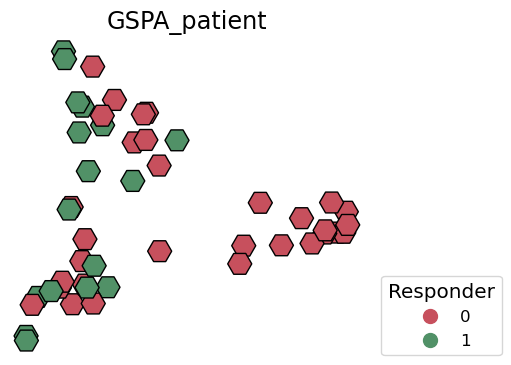

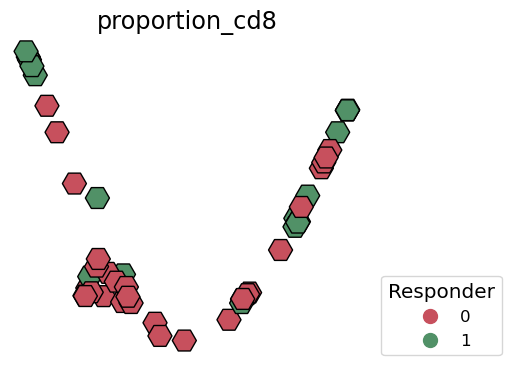

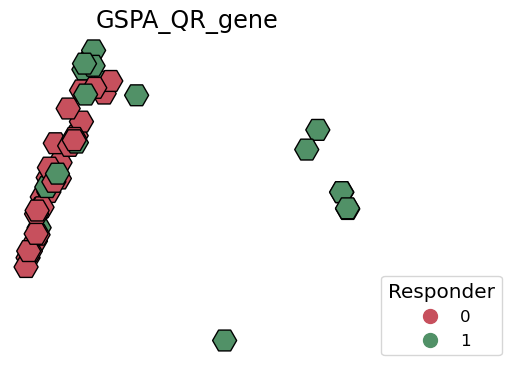

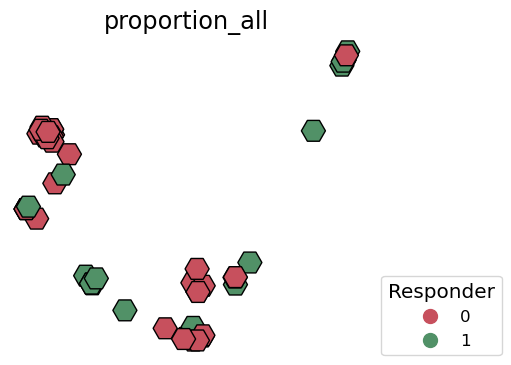

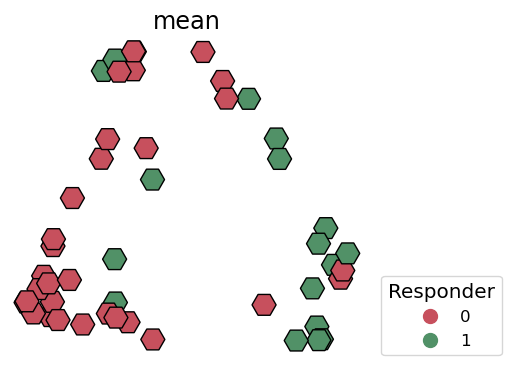

In [13]:
for name, pt_features in datasets.items():
    fig, ax = plt.subplots(figsize=(5.5, 4))
    data_phate = phate.PHATE(verbose=False, random_state=42).fit_transform(pt_features)
    scprep.plot.scatter2d(data_phate, ticks=None, c=y, label_prefix='Patient PHATE', title=name,
                          cmap={0: colors['light berry'], 1: colors['light forest']}, s=300,
                          legend_title='Responder', legend_loc=(1.05,0),
                          dpi=200, marker='H', edgecolor='black', ax=ax)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(f'figures/{name}_patient_embedding.png', dpi=200)

In [25]:
res = {}
all_coefs = {}
for name, dataset in datasets.items():
    auroc = []
    coefs = []
    for i in range(100):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset,y,
                                                                            test_size=0.5, random_state=i)
        clf = linear_model.RidgeClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.decision_function(X_test)
        auroc.append(metrics.roc_auc_score(y_test, y_pred))
        coefs.append(clf.coef_)
        res[name] = auroc

    if name in ['GSPA_QR_gene', 'mean', 'mean_scaled']:
        coefs = np.vstack(np.array(coefs)).mean(axis=0)
        coefs = list(zip(np.hstack(np.array(data.var_names)), coefs))
        g = [x[0] for x in coefs]
        v = [x[1] for x in coefs]
        coef_df = pd.DataFrame((g, v)).T.sort_values(by=1)
        coef_df = coef_df.set_index(0)
        all_coefs[name] = coef_df

    if name in ['GSPA_patient']:
        coefs = np.vstack(np.array(coefs)).mean(axis=0)
        all_coefs[name] = coefs

In [26]:
df = pd.DataFrame(index=['method', 'response_AUROC'], 
                  data=[np.repeat(list(res.keys()), 100), [x for sublist in list(res.values()) for x in sublist]]).T

In [27]:
df = df.groupby('method').mean()
df = df.sort_values('response_AUROC', ascending=False)

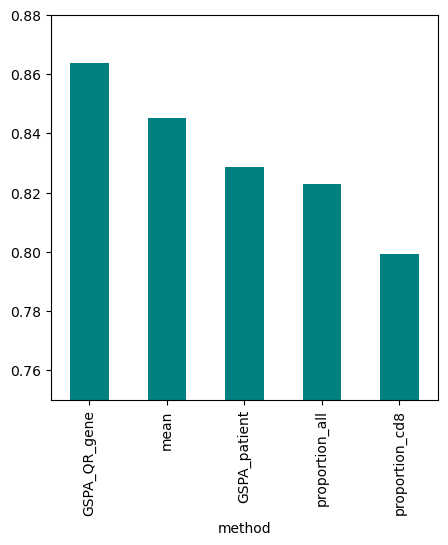

In [29]:
df.loc[['GSPA_QR_gene', 'mean', 'GSPA_patient', 'proportion_all', 'proportion_cd8']]['response_AUROC'].plot(kind='bar', figsize=(5,5), color='teal', ylim=(0.75,0.88))
plt.savefig('figures/response_AUROC.png', dpi=200)